In [1]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import re
import os
import shutil
import uuid
from torch.utils.data import Dataset
from random import shuffle, random
from shutil import move
%matplotlib inline

# Utils

In [2]:
PATTERN = '.*(.+\.pt)$'

def move_data(datapath, train_p=None, val_p=None, test_p=None, train_name='train', test_name='test', validation_name='validation'):
    datapath = os.path.abspath(datapath)
    assert abs(1 - train_p - val_p - test_p) < 1e-5, 'Percentage must sum to 1'
    files = [f for f in os.listdir(datapath) if re.search(PATTERN, f) is not None and os.path.isfile(os.path.join(datapath, f))]
    train_id = int(round(len(files) * train_p))
    val_id = int(round(len(files) * (train_p + val_p)))
    if train_id < 1 or val_id < 1:
        # too few data, move everything to train split
        train_id = val_id = len(files)
    train = files[:train_id]
    val = files[train_id:val_id]
    test = files[val_id:]
    assert len(train) + len(val) + len(test) == len(files), 'Error in splitting data'
    dirnames = (train_name, validation_name, test_name)
    splits = (train, val, test)
    for i, dir in enumerate(dirnames):
        dirpath = os.path.join(datapath, dir)
        if not os.path.exists(dirpath):
            os.mkdir(dirpath)
        for f in splits[i]:
            shutil.move(os.path.join(datapath, f), os.path.join(dirpath, f))

def chunk_data(datapath, chunk_size=1000):
    datapath = os.path.abspath(datapath)
    basename = 'data_'
    chunks = []
    chunk_count = 0
    for entry in os.scandir(datapath):
        if os.path.isfile(entry.path):
            chunks.append(entry.name)
        if len(chunks) == chunk_size:
            dirname = basename + str(chunk_count)
            os.mkdir(os.path.join(datapath, dirname))
            for chunk in chunks:
                move(os.path.join(datapath, chunk), os.path.join(datapath, dirname, chunk))
            chunk_count += 1
            chunks = []
    dirname = basename + str(chunk_count)
    os.mkdir(os.path.join(datapath, dirname))
    for chunk in chunks:
                move(os.path.join(datapath, chunk), os.path.join(datapath, dirname, chunk))            

def collect_files(datapath):
    for entry in os.scandir(os.path.abspath(datapath)):
        if os.path.isfile(entry.path):
            yield entry.path
        elif os.path.isdir(entry.path):
            for nested_entry in collect_files(entry.path):
                yield nested_entry

def custom_collate_fn(batch):
    maps = torch.stack([sample[0].map for sample in batch]).unsqueeze(1)
    starts = torch.stack([sample[0].start for sample in batch])
    goals = torch.stack([sample[0].goal for sample in batch])
    paths = []
    for s in batch:
        sample = s[0]
        path = torch.zeros_like(sample.map, dtype=sample.map.dtype)
        path[sample.path[:, 0], sample.path[:, 1]] = 1.0
        paths.append(path)
    paths = torch.stack(paths)
    return maps, starts, goals, paths

def custom_collate_fn_extended(batch):
    filenames = [sample[1] for sample in batch]
    path_array = [sample[0].path for sample in batch]
    out = list(custom_collate_fn(batch))
    out.extend(filenames)
    out.extend(path_array)
    return out

def get_grid(h, w, to_torch=True):
    coords = np.mgrid[0:h, 0:w].reshape(2, -1)
    grid = np.stack((coords[0], coords[1]), axis=1)
    if to_torch:
        grid = torch.tensor(grid)
    return grid

def get_coords_from_idx(r, c, h, w, idx):
    grid = np.mgrid[max(0, r - 1):min(h, r + 2), max(0, c - 1):min(w, c + 2)]
    return np.stack((grid[0].ravel(), grid[1].ravel())).T[idx]

# Datasets

In [3]:
WHITE = np.array((255, 255, 255), dtype=np.uint8)
RED = np.array((0, 0, 255), dtype=np.uint8)
GREEN = np.array((0, 255, 0), dtype=np.uint8)
BLUE = np.array((255, 0, 0), dtype=np.uint8)


class MapSample(object):
    def __init__(self, map, start, goal, path, device=None):
        super(MapSample, self).__init__()
        if device is None:
            self._device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        else:
            self._device = device
        self.map = torch.tensor(map, dtype=torch.float32, device=self._device)
        self.start = torch.tensor(start, dtype=torch.long, device=self._device)
        self.goal = torch.tensor(goal, dtype=torch.long, device=self._device)
        self.path = torch.tensor(path, dtype=torch.long, device=self._device)

    def to(self, device):
        self._device = device
        self.map = self.map.to(device)
        self.start = self.start.to(device)
        self.goal = self.goal.to(device)
        self.path = self.path.to(device)

    def save(self, path=None):
        self.to('cpu')
        if path is None:
            path = str(uuid.uuid4()) + '.pt'
        torch.save(self, path)

    @staticmethod
    def load(path):
        try:
            sample = torch.load(path)
        except IOError as e:
            print(e)
            sample = None
        return sample

    def bgr_map(self, start_color=RED, goal_color=BLUE, path_color=GREEN):
        map_np, start_np, goal_np, path_np = self.numpy()
        return MapSample.get_bgr_map(map_np, start_np, goal_np, path_np, start_color, goal_color, path_color)

    def numpy(self):
        return self.map.cpu().detach().numpy(), self.start.cpu().detach().numpy(), self.goal.cpu().detach().numpy(), self.path.cpu().detach().numpy()

    @staticmethod
    def get_bgr_map(map, start, goal, path, start_color=RED, goal_color=BLUE, path_color=GREEN, remove_first_path=True):
        h, w = map.shape
        if remove_first_path:
            path = path[1:]
        if type(path) == list or type(path) == tuple:
            path = np.array(path)
        bgr_map = np.zeros((h, w, 3), dtype=np.uint8)
        idx = np.argwhere(map > 0).reshape(-1, 2)
        bgr_map[idx[:, 0], idx[:, 1]] = WHITE
        if np.any(path):
            bgr_map[path[:, 0], path[:, 1]] = path_color
        bgr_map[start[0], start[1]] = start_color
        bgr_map[goal[0], goal[1]] = goal_color
        return bgr_map

    
class MapDataset(Dataset):
    def __init__(self, datapath, lazy=True):
        super(MapDataset, self).__init__()
        datapath = os.path.abspath(datapath)
        self.samples = list(collect_files(datapath))
        shuffle(self.samples)
        self._lazy = lazy
        if not lazy:
            self.samples = [MapSample.load(sample) for sample in self.samples]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        if self._lazy:
            return MapSample.load(self.samples[idx]), self.samples[idx]
        else:
            return self.samples[idx], self.samples[idx]

# Demo

In [4]:
'''
This cell is required since I've messed around with pickle module while serializing data. Sorry for that.
'''
import sys, types
sys.modules['dataset'] = types.ModuleType('dataset')
sys.modules['dataset.map_sample'] = types.ModuleType('map_sample')
sys.modules['dataset.map_sample'].__dict__['MapSample'] = MapSample

torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])
torch.Size([100, 100])


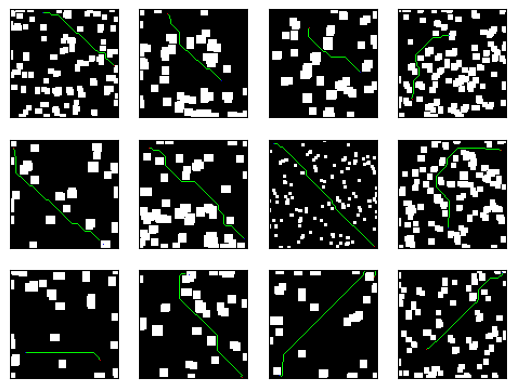

In [10]:
dataset = MapDataset(r'C:\Users\meiri\OneDrive - Technion\Desktop\5th semester\CogRobProject\archive\map_dataset\test')
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols)

for r in range(rows):
    for c in range(cols):
        sample, _ = dataset[round(random() * (len(dataset) - 1))] # 0 - black, 1 - white
        img = cv2.cvtColor(sample.bgr_map(), cv2.COLOR_BGR2RGB)
        axes[r, c].set_xticks([])
        axes[r, c].set_yticks([])
        axes[r, c].imshow(img)
plt.show()

# Save dataset

In [ ]:
torch.save(dataset, 'maps_dataset.pt')